AlphaBuilder v3.1 - Kaggle Training Script
==========================================

This script is designed to run on Kaggle with GPU T4 x2.
Upload this as a Kaggle notebook and enable GPU accelerator.

Expected runtime: ~5 hours for 30 epochs (SimpleBackbone)


## Environment Setup


In [1]:
# ============================================================================

import subprocess
import sys
import os

print("="*60)
print("🚀 AlphaBuilder v3.1 - Kaggle Training")
print("="*60)

# Check GPU
import torch
print(f"\n📊 Hardware Detection:")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"   GPU {i}: {torch.cuda.get_device_name(i)}")
        props = torch.cuda.get_device_properties(i)
        print(f"       Memory: {props.total_memory / 1024**3:.1f} GB")


🚀 AlphaBuilder v3.1 - Kaggle Training

📊 Hardware Detection:
   CUDA available: True
   GPU count: 2
   GPU 0: Tesla T4
       Memory: 14.7 GB
   GPU 1: Tesla T4
       Memory: 14.7 GB


## Clone Repository and Install Dependencies


In [2]:
# ============================================================================

REPO_URL = "https://github.com/gustavomello9600/alphabuild.git"
REPO_DIR = "/kaggle/working/alphabuild"

if not os.path.exists(REPO_DIR):
    print(f"\n📥 Cloning repository...")
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)
else:
    print(f"\n📥 Updating repository...")
    subprocess.run(["git", "-C", REPO_DIR, "pull"], check=True)

# Add to path
sys.path.insert(0, REPO_DIR)
os.chdir(REPO_DIR)

print(f"   Working directory: {os.getcwd()}")



📥 Cloning repository...


Cloning into '/kaggle/working/alphabuild'...


   Working directory: /kaggle/working/alphabuild


Updating files: 100% (100/100), done.


## Download Training Data


In [3]:
# ============================================================================

# Option A: From Kaggle Dataset (recommended)
# Add the dataset "gustavomello9600/alphabuilder-warmup-data" to your notebook

DATA_PATH = "/kaggle/input/alphabuilder-warmup-data/warmup_data_kaggle.db"

# Option B: From Google Drive (backup)
if not os.path.exists(DATA_PATH):
    print("\n⚠️ Dataset not found in Kaggle input.")
    print("   Please add the dataset: gustavomello9600/alphabuilder-warmup-data")
    print("   Or upload warmup_data.db manually.")
    
    # Try local path as fallback
    DATA_PATH = "/kaggle/working/alphabuild/data/warm_up_data/warmup_data.db"
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"Training data not found at {DATA_PATH}")

print(f"\n📂 Training data: {DATA_PATH}")
print(f"   Size: {os.path.getsize(DATA_PATH) / 1024**2:.1f} MB")



📂 Training data: /kaggle/input/alphabuilder-warmup-data/warmup_data_kaggle.db
   Size: 780.7 MB


## Configure Training


In [4]:
# ============================================================================

# Training configuration
CONFIG = {
    'use_swin': False,          # False = SimpleBackbone, True = Swin-UNETR
    'feature_size': 24,
    'batch_size': 32,           # Per GPU (64 total with 2 GPUs)
    'epochs': 30,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'num_workers': 0,
    'use_amp': True,            # Mixed precision
    'val_split': 0.1,
    'patience': 10,             # Early stopping
    'save_every': 5,            # Save checkpoint every N epochs
}

print(f"\n⚙️ Training Configuration:")
for k, v in CONFIG.items():
    print(f"   {k}: {v}")



⚙️ Training Configuration:
   use_swin: False
   feature_size: 24
   batch_size: 32
   epochs: 30
   learning_rate: 0.0001
   weight_decay: 1e-05
   num_workers: 0
   use_amp: True
   val_split: 0.1
   patience: 10
   save_every: 5


## Import and Setup


In [5]:
# ============================================================================

import time
from pathlib import Path
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm

from alphabuilder.src.neural.model import AlphaBuilderV31
from alphabuilder.src.neural.dataset import TopologyDatasetV31
from alphabuilder.src.neural.trainer import policy_loss, weighted_value_loss, LAMBDA_POLICY


## Create DataLoaders


In [6]:
# ============================================================================

print(f"\n📂 Loading dataset...")

full_dataset = TopologyDatasetV31(
    db_path=Path(DATA_PATH),
    augment=True,
    preload_to_ram=True  # Kaggle has enough RAM
)

print(f"   Total samples: {len(full_dataset):,}")

# Split train/val
val_size = int(len(full_dataset) * CONFIG['val_split'])
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"   Train samples: {len(train_dataset):,}")
print(f"   Val samples: {len(val_dataset):,}")

# NOTE: DataLoaders are created fresh each epoch to manage memory
# See training loop for DataLoader configuration

print(f"   DataLoaders will be created per-epoch for memory management")


📂 Loading dataset...
   Total samples: 122,358
   Train samples: 110,123
   Val samples: 12,235
   DataLoaders will be created per-epoch for memory management


## Create Model


In [7]:
# ============================================================================

print(f"\n🧠 Creating model...")

device = torch.device('cuda')

model = AlphaBuilderV31(
    in_channels=7,
    out_channels=2,
    feature_size=CONFIG['feature_size'],
    use_swin=CONFIG['use_swin']
)

total_params = sum(p.numel() for p in model.parameters())
print(f"   Architecture: {'Swin-UNETR' if CONFIG['use_swin'] else 'SimpleBackbone'}")
print(f"   Total parameters: {total_params:,}")

# Multi-GPU
if torch.cuda.device_count() > 1:
    print(f"   Using DataParallel on {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=CONFIG['epochs'],
    eta_min=CONFIG['learning_rate'] * 0.01
)

# Mixed precision
scaler = GradScaler() if CONFIG['use_amp'] else None



🧠 Creating model...
   Architecture: SimpleBackbone
   Total parameters: 745,699
   Using DataParallel on 2 GPUs


/tmp/ipykernel_47/3300993952.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if CONFIG['use_amp'] else None


## Training Functions


In [8]:
# ============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0
    total_p_loss = 0
    total_v_loss = 0
    n_batches = 0
    
    pbar = tqdm(loader, desc="Training", leave=False)
    
    for batch in pbar:
        state = batch['state'].to(device, non_blocking=True)
        target_policy = batch['policy'].to(device, non_blocking=True)
        target_value = batch['value'].to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        if scaler is not None:
            with autocast():
                pred_policy, pred_value = model(state)
                v_loss = weighted_value_loss(pred_value, target_value)
                p_loss = policy_loss(pred_policy, target_policy)
                loss = v_loss + LAMBDA_POLICY * p_loss
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            pred_policy, pred_value = model(state)
            v_loss = weighted_value_loss(pred_value, target_value)
            p_loss = policy_loss(pred_policy, target_policy)
            loss = v_loss + LAMBDA_POLICY * p_loss
            
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        total_p_loss += p_loss.item()
        total_v_loss += v_loss.item()
        n_batches += 1
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return {
        'loss': total_loss / n_batches,
        'policy_loss': total_p_loss / n_batches,
        'value_loss': total_v_loss / n_batches,
    }


def validate_epoch(model, loader, device):
    model.eval()
    total_loss = 0
    total_p_loss = 0
    total_v_loss = 0
    n_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating", leave=False):
            state = batch['state'].to(device, non_blocking=True)
            target_policy = batch['policy'].to(device, non_blocking=True)
            target_value = batch['value'].to(device, non_blocking=True)
            
            with autocast():
                pred_policy, pred_value = model(state)
                v_loss = weighted_value_loss(pred_value, target_value)
                p_loss = policy_loss(pred_policy, target_policy)
                loss = v_loss + LAMBDA_POLICY * p_loss
            
            total_loss += loss.item()
            total_p_loss += p_loss.item()
            total_v_loss += v_loss.item()
            n_batches += 1
    
    return {
        'loss': total_loss / n_batches,
        'policy_loss': total_p_loss / n_batches,
        'value_loss': total_v_loss / n_batches,
    }


## Training Loop


In [9]:
def get_memory_info():
    """Get current GPU and RAM memory usage."""
    import psutil
    ram_percent = psutil.virtual_memory().percent
    ram_used = psutil.virtual_memory().used / 1024**3
    
    if torch.cuda.is_available():
        gpu_allocated = torch.cuda.memory_allocated() / 1024**3
        gpu_reserved = torch.cuda.memory_reserved() / 1024**3
        return f"RAM: {ram_used:.1f}GB ({ram_percent:.0f}%) | GPU: {gpu_allocated:.1f}GB alloc / {gpu_reserved:.1f}GB reserved"
    return f"RAM: {ram_used:.1f}GB ({ram_percent:.0f}%)"
print(f"\n🚀 Starting training: {CONFIG['epochs']} epochs")
print("-" * 60)
print(f"📊 Initial memory: {get_memory_info()}")
checkpoint_dir = Path("/kaggle/working/checkpoints")
checkpoint_dir.mkdir(exist_ok=True)
best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'val_loss': [], 'lr': []}
batch_size = CONFIG['batch_size'] * max(1, torch.cuda.device_count())
num_workers = CONFIG['num_workers']
training_start = time.time()
for epoch in range(CONFIG['epochs']):
    epoch_start = time.time()
    
    # Create fresh train loader
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
    )
    
    train_metrics = train_epoch(model, train_loader, optimizer, scaler, device)
    
    # Cleanup
    del train_loader
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    print(f"  📊 After train cleanup: {get_memory_info()}")
    
    # Create fresh val loader
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    val_metrics = validate_epoch(model, val_loader, device)
    
    del val_loader
    gc.collect()
    torch.cuda.empty_cache()
    print(f"  📊 After val cleanup: {get_memory_info()}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    history['train_loss'].append(train_metrics['loss'])
    history['val_loss'].append(val_metrics['loss'])
    history['lr'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    samples_per_sec = len(train_dataset) / epoch_time
    
    print(f"\nEpoch {epoch + 1}/{CONFIG['epochs']} ({epoch_time:.1f}s, {samples_per_sec:.0f} samples/s)")
    print(f"  Train | Loss: {train_metrics['loss']:.4f} | P: {train_metrics['policy_loss']:.4f} | V: {train_metrics['value_loss']:.4f}")
    print(f"  Val   | Loss: {val_metrics['loss']:.4f} | P: {val_metrics['policy_loss']:.4f} | V: {val_metrics['value_loss']:.4f}")
    print(f"  LR: {current_lr:.2e}")
    
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        patience_counter = 0
        torch.cuda.empty_cache()
        model_state = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            'config': CONFIG,
        }, checkpoint_dir / "best_model.pt")
        print(f"  ✓ New best model saved (val_loss: {best_val_loss:.4f})")
        del model_state
    else:
        patience_counter += 1
    
    if (epoch + 1) % CONFIG['save_every'] == 0:
        model_state = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_metrics['loss'],
            'config': CONFIG,
        }, checkpoint_dir / f"checkpoint_epoch_{epoch + 1}.pt")
        del model_state
    
    if patience_counter >= CONFIG['patience']:
        print(f"\n⚠️ Early stopping triggered (patience={CONFIG['patience']})")
        break


🚀 Starting training: 30 epochs
------------------------------------------------------------
📊 Initial memory: RAM: 25.8GB (82%) | GPU: 0.0GB alloc / 0.0GB reserved


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

/tmp/ipykernel_47/924035892.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

/tmp/ipykernel_47/924035892.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 1/30 (680.9s, 162 samples/s)
  Train | Loss: 0.7892 | P: 0.3372 | V: 0.4521
  Val   | Loss: 0.3237 | P: 0.1728 | V: 0.1509
  LR: 9.97e-05
  ✓ New best model saved (val_loss: 0.3237)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 2/30 (678.9s, 162 samples/s)
  Train | Loss: 0.2413 | P: 0.1117 | V: 0.1296
  Val   | Loss: 0.1623 | P: 0.0730 | V: 0.0893
  LR: 9.89e-05
  ✓ New best model saved (val_loss: 0.1623)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 3/30 (678.8s, 162 samples/s)
  Train | Loss: 0.1445 | P: 0.0563 | V: 0.0882
  Val   | Loss: 0.1055 | P: 0.0441 | V: 0.0614
  LR: 9.76e-05
  ✓ New best model saved (val_loss: 0.1055)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 4/30 (677.4s, 163 samples/s)
  Train | Loss: 0.1038 | P: 0.0376 | V: 0.0662
  Val   | Loss: 0.0879 | P: 0.0328 | V: 0.0551
  LR: 9.57e-05
  ✓ New best model saved (val_loss: 0.0879)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 5/30 (676.6s, 163 samples/s)
  Train | Loss: 0.0836 | P: 0.0293 | V: 0.0543
  Val   | Loss: 0.0729 | P: 0.0267 | V: 0.0462
  LR: 9.34e-05
  ✓ New best model saved (val_loss: 0.0729)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 6/30 (678.8s, 162 samples/s)
  Train | Loss: 0.0735 | P: 0.0250 | V: 0.0486
  Val   | Loss: 0.0664 | P: 0.0236 | V: 0.0428
  LR: 9.05e-05
  ✓ New best model saved (val_loss: 0.0664)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 7/30 (680.5s, 162 samples/s)
  Train | Loss: 0.0652 | P: 0.0223 | V: 0.0429
  Val   | Loss: 0.0593 | P: 0.0214 | V: 0.0380
  LR: 8.73e-05
  ✓ New best model saved (val_loss: 0.0593)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 8/30 (674.0s, 163 samples/s)
  Train | Loss: 0.0573 | P: 0.0208 | V: 0.0366
  Val   | Loss: 0.0556 | P: 0.0204 | V: 0.0352
  LR: 8.36e-05
  ✓ New best model saved (val_loss: 0.0556)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 9/30 (671.9s, 164 samples/s)
  Train | Loss: 0.0544 | P: 0.0199 | V: 0.0345
  Val   | Loss: 0.0529 | P: 0.0196 | V: 0.0333
  LR: 7.96e-05
  ✓ New best model saved (val_loss: 0.0529)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 10/30 (675.3s, 163 samples/s)
  Train | Loss: 0.0517 | P: 0.0192 | V: 0.0325
  Val   | Loss: 0.0491 | P: 0.0192 | V: 0.0299
  LR: 7.52e-05
  ✓ New best model saved (val_loss: 0.0491)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 11/30 (675.0s, 163 samples/s)
  Train | Loss: 0.0493 | P: 0.0188 | V: 0.0305
  Val   | Loss: 0.0428 | P: 0.0186 | V: 0.0242
  LR: 7.06e-05
  ✓ New best model saved (val_loss: 0.0428)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 12/30 (674.2s, 163 samples/s)
  Train | Loss: 0.0465 | P: 0.0184 | V: 0.0281
  Val   | Loss: 0.0438 | P: 0.0185 | V: 0.0253
  LR: 6.58e-05


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 13/30 (676.4s, 163 samples/s)
  Train | Loss: 0.0446 | P: 0.0181 | V: 0.0264
  Val   | Loss: 0.0453 | P: 0.0183 | V: 0.0270
  LR: 6.08e-05


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.9GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 14/30 (678.4s, 162 samples/s)
  Train | Loss: 0.0421 | P: 0.0179 | V: 0.0242
  Val   | Loss: 0.0390 | P: 0.0177 | V: 0.0212
  LR: 5.57e-05
  ✓ New best model saved (val_loss: 0.0390)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.9GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 15/30 (677.6s, 163 samples/s)
  Train | Loss: 0.0418 | P: 0.0177 | V: 0.0241
  Val   | Loss: 0.0351 | P: 0.0176 | V: 0.0176
  LR: 5.05e-05
  ✓ New best model saved (val_loss: 0.0351)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 16/30 (673.3s, 164 samples/s)
  Train | Loss: 0.0395 | P: 0.0175 | V: 0.0221
  Val   | Loss: 0.0402 | P: 0.0176 | V: 0.0227
  LR: 4.53e-05


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.9GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 17/30 (675.1s, 163 samples/s)
  Train | Loss: 0.0372 | P: 0.0172 | V: 0.0200
  Val   | Loss: 0.0370 | P: 0.0175 | V: 0.0195
  LR: 4.02e-05


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.9GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.9GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 18/30 (674.9s, 163 samples/s)
  Train | Loss: 0.0367 | P: 0.0171 | V: 0.0196
  Val   | Loss: 0.0322 | P: 0.0172 | V: 0.0151
  LR: 3.52e-05
  ✓ New best model saved (val_loss: 0.0322)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.9GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 19/30 (675.3s, 163 samples/s)
  Train | Loss: 0.0356 | P: 0.0169 | V: 0.0187
  Val   | Loss: 0.0386 | P: 0.0170 | V: 0.0215
  LR: 3.04e-05


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 20/30 (674.7s, 163 samples/s)
  Train | Loss: 0.0346 | P: 0.0168 | V: 0.0178
  Val   | Loss: 0.0362 | P: 0.0170 | V: 0.0191
  LR: 2.58e-05


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 21/30 (672.0s, 164 samples/s)
  Train | Loss: 0.0330 | P: 0.0167 | V: 0.0163
  Val   | Loss: 0.0341 | P: 0.0169 | V: 0.0172
  LR: 2.14e-05


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 22/30 (676.0s, 163 samples/s)
  Train | Loss: 0.0332 | P: 0.0167 | V: 0.0166
  Val   | Loss: 0.0319 | P: 0.0168 | V: 0.0150
  LR: 1.74e-05
  ✓ New best model saved (val_loss: 0.0319)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 23/30 (674.2s, 163 samples/s)
  Train | Loss: 0.0320 | P: 0.0166 | V: 0.0154
  Val   | Loss: 0.0313 | P: 0.0167 | V: 0.0146
  LR: 1.37e-05
  ✓ New best model saved (val_loss: 0.0313)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 24/30 (673.4s, 164 samples/s)
  Train | Loss: 0.0306 | P: 0.0165 | V: 0.0142
  Val   | Loss: 0.0321 | P: 0.0167 | V: 0.0153
  LR: 1.05e-05


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 25/30 (674.6s, 163 samples/s)
  Train | Loss: 0.0309 | P: 0.0164 | V: 0.0145
  Val   | Loss: 0.0305 | P: 0.0166 | V: 0.0140
  LR: 7.63e-06
  ✓ New best model saved (val_loss: 0.0305)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 26/30 (676.0s, 163 samples/s)
  Train | Loss: 0.0311 | P: 0.0164 | V: 0.0148
  Val   | Loss: 0.0307 | P: 0.0165 | V: 0.0142
  LR: 5.28e-06


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 27/30 (675.2s, 163 samples/s)
  Train | Loss: 0.0289 | P: 0.0163 | V: 0.0126
  Val   | Loss: 0.0327 | P: 0.0165 | V: 0.0162
  LR: 3.42e-06


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 28/30 (676.5s, 163 samples/s)
  Train | Loss: 0.0312 | P: 0.0163 | V: 0.0149
  Val   | Loss: 0.0292 | P: 0.0165 | V: 0.0126
  LR: 2.08e-06
  ✓ New best model saved (val_loss: 0.0292)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 29/30 (677.3s, 163 samples/s)
  Train | Loss: 0.0293 | P: 0.0162 | V: 0.0131
  Val   | Loss: 0.0283 | P: 0.0164 | V: 0.0119
  LR: 1.27e-06
  ✓ New best model saved (val_loss: 0.0283)


Training:   0%|          | 0/1720 [00:00<?, ?it/s]

  📊 After train cleanup: RAM: 26.8GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved


Validating:   0%|          | 0/192 [00:00<?, ?it/s]

  📊 After val cleanup: RAM: 26.9GB (86%) | GPU: 0.0GB alloc / 0.2GB reserved

Epoch 30/30 (676.1s, 163 samples/s)
  Train | Loss: 0.0288 | P: 0.0163 | V: 0.0125
  Val   | Loss: 0.0287 | P: 0.0166 | V: 0.0120
  LR: 1.00e-06


## Final Summary



🎉 Training Complete!
   Total time: 5.6 hours
   Best validation loss: 0.0283
   Checkpoints saved to: /kaggle/working/checkpoints

📁 Saved files:
   best_model.pt (8.6 MB)
   checkpoint_epoch_10.pt (8.6 MB)
   checkpoint_epoch_15.pt (8.6 MB)
   checkpoint_epoch_20.pt (8.6 MB)
   checkpoint_epoch_25.pt (8.6 MB)
   checkpoint_epoch_30.pt (8.6 MB)
   checkpoint_epoch_5.pt (8.6 MB)


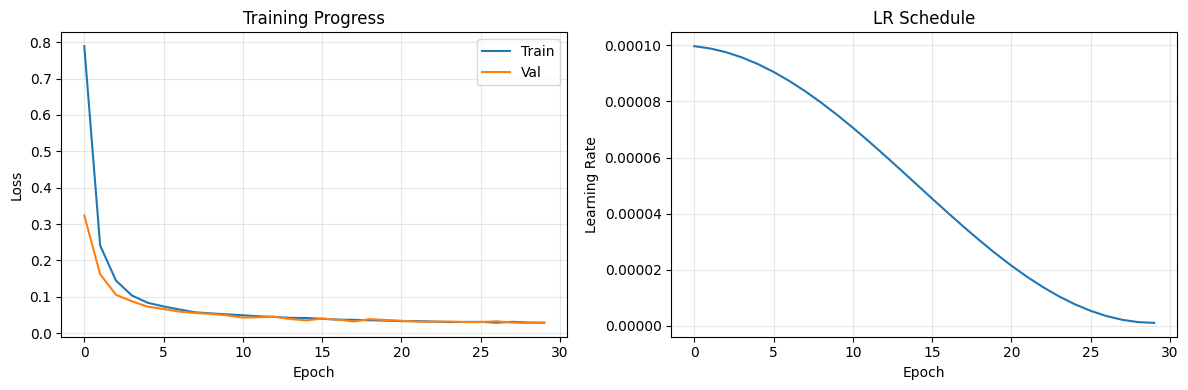


📊 Training history saved to: /kaggle/working/checkpoints/training_history.png

✅ Done! Download checkpoints from /kaggle/working/checkpoints/


In [10]:
# ============================================================================

total_time = time.time() - training_start

print("\n" + "=" * 60)
print("🎉 Training Complete!")
print("=" * 60)
print(f"   Total time: {total_time / 3600:.1f} hours")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Checkpoints saved to: {checkpoint_dir}")

# List saved files
print(f"\n📁 Saved files:")
for f in sorted(checkpoint_dir.glob("*.pt")):
    print(f"   {f.name} ({f.stat().st_size / 1024**2:.1f} MB)")

# Plot training history
try:
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Val')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history['lr'])
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('LR Schedule')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(checkpoint_dir / "training_history.png", dpi=150)
    plt.show()
    print(f"\n📊 Training history saved to: {checkpoint_dir / 'training_history.png'}")
except Exception as e:
    print(f"\n⚠️ Could not plot history: {e}")

print("\n✅ Done! Download checkpoints from /kaggle/working/checkpoints/")


In [19]:
# Listar arquivos
!ls -la /kaggle/working/checkpoints/
# Copiar para output root (mais visível na UI)
!cp /kaggle/working/checkpoints/*.pt /kaggle/working/
!ls -la /kaggle/working/*.pt

total 61540
drwxr-xr-x 2 root root    4096 Dec  5 15:45 .
drwxr-xr-x 6 root root    4096 Dec  5 10:25 ..
-rw-r--r-- 1 root root 8985910 Dec  5 15:33 best_model.pt
-rw-r--r-- 1 root root 8987026 Dec  5 11:59 checkpoint_epoch_10.pt
-rw-r--r-- 1 root root 8987026 Dec  5 12:56 checkpoint_epoch_15.pt
-rw-r--r-- 1 root root 8987026 Dec  5 13:52 checkpoint_epoch_20.pt
-rw-r--r-- 1 root root 8987026 Dec  5 14:48 checkpoint_epoch_25.pt
-rw-r--r-- 1 root root 8987026 Dec  5 15:45 checkpoint_epoch_30.pt
-rw-r--r-- 1 root root 8986902 Dec  5 11:03 checkpoint_epoch_5.pt
-rw-r--r-- 1 root root   75065 Dec  5 15:45 training_history.png
-rw-r--r-- 1 root root 8985910 Dec  5 16:15 /kaggle/working/best_model.pt
-rw-r--r-- 1 root root 8987026 Dec  5 16:15 /kaggle/working/checkpoint_epoch_10.pt
-rw-r--r-- 1 root root 8987026 Dec  5 16:15 /kaggle/working/checkpoint_epoch_15.pt
-rw-r--r-- 1 root root 8987026 Dec  5 16:15 /kaggle/working/checkpoint_epoch_20.pt
-rw-r--r-- 1 root root 8987026 Dec  5 16:15 /kag